#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [70]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [72]:
# loading nasdaq-100 stock data

stock_data = qndata.stocks.load_spx_data(tail = 365 * 5, assets =['NAS:AAPL', 'NAS:AMZN', 'NAS:GOOGL', 'NAS:MSFT', 'NAS:NVDA', 'NYS:BRK.B', 'NYS:V', 'NAS:TSLA', 'NYS:PG', 'NAS:META',
 'NYS:JNJ', 'NAS:AMD', 'NAS:INTC', 'NAS:CSCO', 'NYS:MA', 'NYS:WMT', 'NYS:DIS', 'NYS:PYPL', 'NYS:HD', 'NYS:KO'])
# These assets represent a mix of key sectors, primarily technology, consumer goods, and healthcare, along with some exposure to energy and financial services. 
# They offer a combination of stability from large-cap companies, growth potential from tech innovators, and defensive qualities from sectors like healthcare and consumer staples. 
# This diversity makes them suitable for algorithmic trading strategies that aim to balance risk and opportunity.

fetched chunk 1/1 0s
Data loaded 0s


In [73]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    #atr,The Average True Range (ATR) is useful in algorithmic trading as it measures market volatility. It helps in setting dynamic stop-loss levels,
    #position sizing, and identifying potential breakouts or trend reversals. Using ATR ensures strategies adapt to changing market conditions,
    #improving risk management and decision-making.
    vol = data.sel(field="vol")
    liq = data.sel(field="is_liquid")
    close = data.sel(field="close")
    high = data.sel(field="high")
    low = data.sel(field="low")
    atr = qnta.atr(high=high, low=low, close=close, ma=14)

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price],
        pd.Index(
            ["trend",  "macd", "stochastic_d", "rsi", "price", "atr"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [74]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:AMD,NAS:AMZN,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:BRK.B,NYS:DIS,NYS:HD,NYS:JNJ,NYS:KO,NYS:MA,NYS:PG,NYS:PYPL,NYS:V,NYS:WMT
time,,,,,,,,,,,,,,,,,,,,
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,-0.130814,-0.447468,0.141207,0.093595,0.229914,-0.369564,0.110697,-0.021084,-0.144971,0.518485,0.014686,-0.048049,0.035598,-0.091337,-0.074032,0.015295,-0.163261,NaN,0.107177,0.089404
2025-01-17,-0.106117,-0.356911,0.212347,0.113530,0.275262,-0.080750,0.115436,0.012081,-0.045413,0.595236,0.051626,-0.036043,0.036759,-0.101400,-0.042877,0.024369,-0.147720,NaN,0.127287,0.106371
2025-01-21,-0.204481,-0.321817,0.274147,0.154591,0.301229,-0.033878,0.132028,0.006728,0.030839,0.542554,0.055574,0.008490,0.109850,-0.070851,-0.052196,0.044428,-0.133662,NaN,0.163448,0.140584


In [75]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""
    daily_return = qnta.change(data.sel(field="close"))/(data.sel(field="close").shift(time=+1))
    daily_return_future  = daily_return.shift(time=-1)
 
    move = 0.005
 
    class_positive = 1 # prices goes more than move*100%
    class_neutral  = 0 # price dein not move more than move*100%
    class_negative = -1 # price goes down more than move*100%
 
 
    target_price = xr.where(daily_return_future  < -move, class_negative, daily_return_future)
    target_price = xr.where(target_price > move, class_positive, target_price)
    target_price = xr.where(abs(target_price) != 1, class_neutral, target_price)
 
    return target_price

In [76]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:AMD,NAS:AMZN,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:BRK.B,NYS:DIS,NYS:HD,NYS:JNJ,NYS:KO,NYS:MA,NYS:PG,NYS:PYPL,NYS:V,NYS:WMT
time,,,,,,,,,,,,,,,,,,,,
2020-01-28,1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,-1.0,0.0,1.0,-1.0
2020-01-29,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2020-01-30,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
2020-01-31,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2020-02-03,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,1.0
2025-01-17,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2025-01-21,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0


In [77]:
def get_model():
    """
The Ridge regression model is a solid choice because it addresses multicollinearity by adding an L2 regularization term, which prevents overfitting
and improves the model's generalization on datasets with highly correlated features.
    """

    model = linear_model.Ridge(alpha=.5)
    return model

In [78]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:AAPL': Ridge(alpha=0.5), 'NAS:AMD': Ridge(alpha=0.5), 'NAS:AMZN': Ridge(alpha=0.5), 'NAS:CSCO': Ridge(alpha=0.5), 'NAS:GOOGL': Ridge(alpha=0.5), 'NAS:INTC': Ridge(alpha=0.5), 'NAS:META': Ridge(alpha=0.5), 'NAS:MSFT': Ridge(alpha=0.5), 'NAS:NVDA': Ridge(alpha=0.5), 'NAS:TSLA': Ridge(alpha=0.5), 'NYS:BRK.B': Ridge(alpha=0.5), 'NYS:DIS': Ridge(alpha=0.5), 'NYS:HD': Ridge(alpha=0.5), 'NYS:JNJ': Ridge(alpha=0.5), 'NYS:KO': Ridge(alpha=0.5), 'NYS:MA': Ridge(alpha=0.5), 'NYS:PG': Ridge(alpha=0.5), 'NYS:V': Ridge(alpha=0.5), 'NYS:WMT': Ridge(alpha=0.5)}


Feature: 0, Score: -0.09490
Feature: 1, Score: -0.00079
Feature: 2, Score: -0.34527
Feature: 3, Score: 0.00261
Feature: 4, Score: -0.00504
Feature: 5, Score: -0.22573


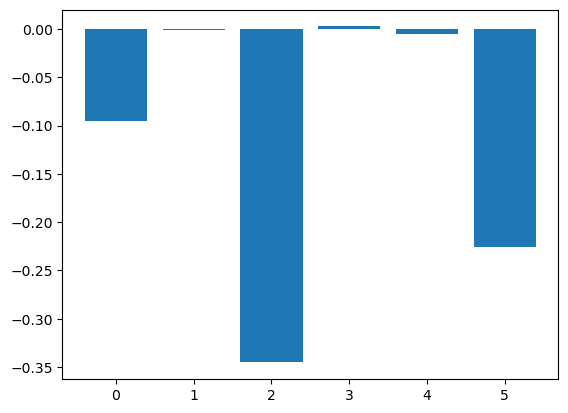

In [79]:
# Showing which features are more important in predicting:

importance = models["NAS:AAPL"].coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [80]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 20)> Size: 201kB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00512362,  0.05025333,  0.00437126, ...,  0.        ,
        -0.06091057,  0.14875387],
       [-0.0062199 ,  0.04002376, -0.00836705, ...,  0.        ,
        -0.05403959,  0.1886116 ],
       [ 0.0024023 ,  0.03959714, -0.01732637, ...,  0.        ,
        -0.05898043,  0.20761355]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:AMD' ... 'NYS:V' 'NYS:WMT'
  * time     (time) datetime64[ns] 10kB 2020-01-28 2020-01-29 ... 2025-01-23
    field    <U5 20B 'close'


In [81]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

2.459939611106137

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [82]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-16,5.228271,0.002631,0.161395,-0.007909,-0.1774,2.438602,0.393577,0.462097,19.0,0.250954,7.241917
2025-01-17,5.251130,0.004372,0.161336,-0.003571,-0.1774,2.444759,0.394427,0.336243,19.0,0.251006,7.242184
2025-01-21,5.284268,0.006311,0.161286,0.000000,-0.1774,2.454111,0.395815,0.325935,19.0,0.251001,7.241947
2025-01-22,5.318929,0.006559,0.161239,0.000000,-0.1774,2.463868,0.397271,0.218668,19.0,0.250980,7.240124
2025-01-23,5.311190,-0.001455,0.161179,-0.001455,-0.1774,2.459940,0.396492,0.156193,19.0,0.250980,7.254907


time,2025-01-23
field,
sharpe_ratio,2.45994



Ok. This strategy does not correlate with other strategies.


In [83]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.005939434148595067

In [84]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.05577068619362824

In [85]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.6834486789609694

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [86]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [87]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [88]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_s&p500",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/2 0s
fetched chunk 2/2 0s
Data loaded 0s
fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...
fetched chunk 1/2 0s
fetched chunk 2/2 0s
Data loaded 0s
---
Run all iterations...
Load data...
fetched chunk 1/15 0s
fetched chunk 2/15 0s
fetched chunk 3/15 0s
fetched chunk 4/15 0s
fetched chunk 5/15 0s
fetched chunk 6/15 0s
fetched chunk 7/15 0s
fetched chunk 8/15 0s
fetched chunk 9/15 1s
fetched chunk 10/15 1s
fetched chunk 11/15 1s
fetched chunk 12/15 1s
fetched chunk 13/15 1s
fetched chunk 14/15 1s
fetched chunk 15/15 1s
Data loaded 1s
fetched chunk 1/13 0s
fetched chunk 2/13 0s
fetched chunk 3/13 0s
fetched chunk 4/13 0s
fetched chunk 5/13 0s
fetched chunk 6/13 0s
fetc

100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13044156 of 13044156) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/13 1s


100% (13044160 of 13044160) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/13 2s


100% (13044156 of 13044156) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/13 3s


100% (13044160 of 13044160) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/13 4s


100% (13044132 of 13044132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/13 6s


100% (13044052 of 13044052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/13 7s


100% (13044052 of 13044052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/13 8s


100% (12997900 of 12997900) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/13 9s


100% (13044052 of 13044052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 9/13 10s


100% (12997900 of 12997900) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 10/13 11s


100% (13044052 of 13044052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 11/13 13s


100% (13044052 of 13044052) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 12/13 14s


100% (11741812 of 11741812) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 13/13 15s
Data loaded 16s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-23
Sharpe Ratio = -0.15293988834898908


ERROR! The Sharpe Ratio is too low. -0.15293988834898908 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5047 of 5047) |####################| Elapsed Time: 0:16:43 Time:  0:16:43


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!